# Project Description

This project creates an NLP model for a multi-class classification problem. The data used is bbc news data which contains the contents of the news and the news category as its class. The model is made with a sequential model, namely **Simple-BiLSTM**. As the name implies, the layer architecture in this model uses a Bidirectional LSTM layer. With a relatively short training time, the model is able to achieve accuracy and validation accuracy above 91%.

In this project, also perform prediction simulations using models that can be embedded in web apps/android apps. From the simulation, the model can predict the user input sample correctly.

# Preparation

In [1]:
# lib prep.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from google.colab import drive
drive.mount('/drive')
import zipfile
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
# from sklearn.preprocessing import MinMaxScaler
import pickle

Mounted at /drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Preparation

In [2]:
# loading data
data = pd.read_csv('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv')

# check top-5 data
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
# check bottom-5 data
data.tail()

,category,text
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...
2224,sport,souness delight at euro progress boss graeme s...


In [4]:
# check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


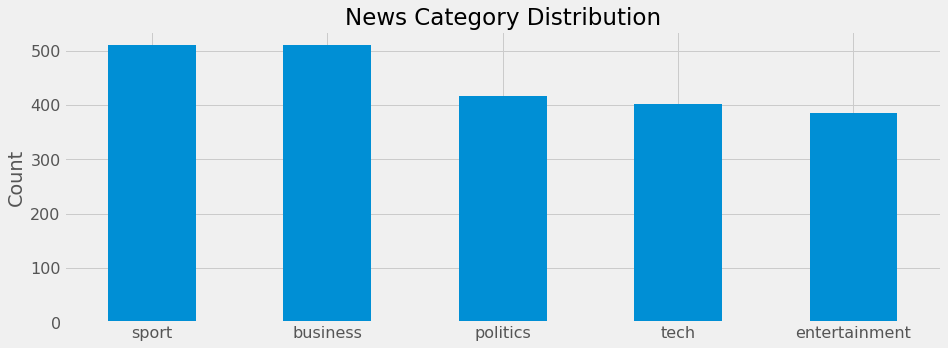

In [5]:
# check news category distribution
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})
data['category'].value_counts()\
                .sort_values(ascending=False)\
                .plot(kind='bar', title='News Category Distribution', 
                      figsize=(14,5), fontsize=16, rot=0, ylabel='Count')

In [6]:
def remove_stopwords(sentence):
    '''
    This function for removing stopwords in the text

    input:
    > sentence: raw sentence

    Output:
    > sentence without stopwords
    '''
    for word in stopwords.words('english'):
        token = ' '+word+' '
        sentence = sentence.lower().replace(token, ' ')
    return sentence

In [7]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
padding_type='post'
oov_tok = '-'
data_clean = data.copy()

# Removing Stopwords
label = data_clean['category']
sentence = data_clean['text'].apply(lambda u:remove_stopwords(u))

# Split data
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, 
                                                                        label,
                                                                        test_size=0.2,
                                                                        random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentence_train)
tokenizer.fit_on_texts(sentence_test)
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(label)

# Conversion text to sequence
seq_sentence_train = tokenizer.texts_to_sequences(sentence_train)
seq_sentence_test = tokenizer.texts_to_sequences(sentence_test)

# Text padding
padded_seq_sentence_train = pad_sequences(seq_sentence_train, padding=padding_type, maxlen=max_length)
padded_seq_sentence_test = pad_sequences(seq_sentence_test, padding=padding_type, maxlen=max_length)
label_train_seq = np.array(label_tokenizer.texts_to_sequences(label_train))
label_test_seq = np.array(label_tokenizer.texts_to_sequences(label_test))

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>0.95 and (logs.get('val_accuracy') > 0.91):
            print('Acc & Val Acc reach more than 91%, stop training...')
            self.model.stop_training = True

model = tf.keras.Sequential(name='Simple-BiLSTM', layers=[
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(6, activation='softmax')
            ])

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), metrics=['accuracy'])

Model: "Simple-BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 100)          26800     
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 43,406
Trainable params: 43,406
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(padded_seq_sentence_train, label_train_seq, epochs=100,
                    validation_data=(padded_seq_sentence_test, label_test_seq), 
                    verbose=1,
                    callbacks=[myCallback()])

Epoch 1/100
56/56 [==============================] - 10s 113ms/step - loss: 1.3418 - accuracy: 0.4534 - val_loss: 0.7771 - val_accuracy: 0.6764
Epoch 2/100
56/56 [==============================] - 5s 97ms/step - loss: 0.5208 - accuracy: 0.8258 - val_loss: 0.5197 - val_accuracy: 0.8337
Epoch 3/100
56/56 [==============================] - 6s 99ms/step - loss: 0.2334 - accuracy: 0.9275 - val_loss: 0.4152 - val_accuracy: 0.8494
Epoch 4/100
56/56 [==============================] - 5s 98ms/step - loss: 0.1628 - accuracy: 0.9494 - val_loss: 0.2747 - val_accuracy: 0.9079
Epoch 5/100
56/56 [==============================] - 5s 98ms/step - loss: 0.1147 - accuracy: 0.9624 - val_loss: 0.5042 - val_accuracy: 0.8382
Epoch 6/100
56/56 [==============================] - 5s 98ms/step - loss: 0.0918 - accuracy: 0.9702 - val_loss: 0.3966 - val_accuracy: 0.8876
Epoch 7/100
56/56 [==============================] - 5s 98ms/step - loss: 0.0561 - accuracy: 0.9809 - val_loss: 0.3304 - val_accuracy: 0.9169
Acc 

(0.0, 6.3)

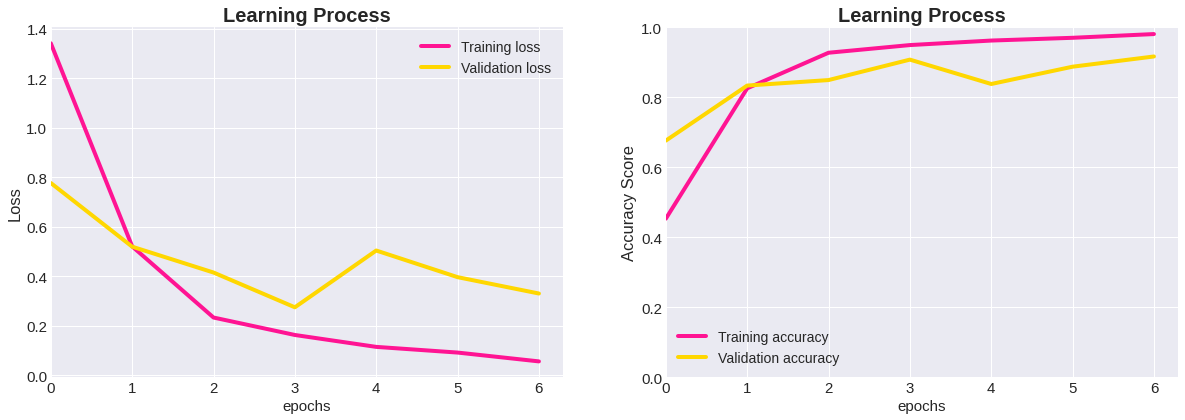

In [10]:
plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='deeppink', label='Training loss')
axs[0].plot(history.history['val_loss'], color='gold', label='Validation loss')    
axs[0].set_title('Learning Process', fontsize=20, fontweight='heavy')
axs[0].set_xlabel('epochs', fontsize=15)
axs[0].set_ylabel('Loss', fontsize=16.5)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].legend(loc='best', shadow=True, prop={'size': 14})
axs[0].set_xlim(left=0)
axs[1].plot(history.history['accuracy'], color='deeppink', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='gold', label='Validation accuracy')
axs[1].set_title('Learning Process', fontsize=20, fontweight='heavy')
axs[1].set_xlabel('epochs', fontsize=15)
axs[1].set_ylabel('Accuracy Score', fontsize=16.5)
axs[1].set_ylim(0,1)
axs[1].tick_params(axis='both', labelsize=15)
axs[1].legend(loc='best', shadow=True, prop={'size': 14})
axs[1].set_xlim(left=0)

# Simulation for Prediction

In [11]:
# saving tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving model
model.save('model_nlp.h5')

# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer_ = pickle.load(handle)

# load model
savedModel=load_model('model_nlp.h5')
savedModel.summary()

Model: "Simple-BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 100)          26800     
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 43,406
Trainable params: 43,406
Non-trainable params: 0
_________________________________________________________________


In [12]:
# check label
print(label_train[:15])
print(label_train_seq[:15])

1490    entertainment
2001         business
1572         business
1840    entertainment
610              tech
23              sport
1904             tech
427              tech
861              tech
988             sport
1190    entertainment
198              tech
49           business
173          politics
2098         business
Name: category, dtype: object
[[5]
 [2]
 [2]
 [5]
 [4]
 [1]
 [4]
 [4]
 [4]
 [1]
 [5]
 [4]
 [2]
 [3]
 [2]]


In [13]:
lbl = ['sport', 'business', 'politics', 'tech', 'entertainment']

In [14]:
sentence_input = 'A novel way of delivering high-speed internet via beams of light through the air has successfully transmitted data across the Congo River. It means that citizens in Brazzaville and Kinshasa could get faster and cheaper broadband. Project Taara is one of Alphabet X\'s (formerly Google X) so-called moonshot ideas. It grew out of Project Loon, a broadband project using balloons in the stratosphere, since shut down.'
                #   # other example 
                #   'cricket has become a sport that never stops, but though the Indian Premier League restarts this weekend and the bandwagon keeps rolling we have also reached the end of the British summer, as good a time as any to take stock and assess where we are and what the future holds. For England, there are some easy answers and some harder ones. In terms of cricket it has been a solid few months, with success in the short-form game balancing out some disappointment in the Tests. But the way the men’s international summer ended, with the abandonment of the fifth Test of a superb series against India, demonstrated a sport in the middle of a transformation. The growth of franchise cricket and the success of the IPL has brought a massive rise in player power. Add to that a pandemic that forced new demands on top players, particularly those who perform across all three formats, and it was only a matter of time before they started deciding that some of the things that were being asked of them were unreasonable.'
                  
sentence_input_prep = [remove_stopwords(sentence_input)]
seq = tokenizer_.texts_to_sequences(sentence_input_prep)
pad = pad_sequences(seq, padding='post', maxlen=120)
pred = savedModel.predict(pad)
pred_lbl = lbl[np.argmax(pred)-1]
print(pred_lbl)

tech
